# Travail pratique 3
*INF600F - Traitement d'images (A2024, UQÀM)*

* Indiquez ici votre Vahid Foruzanmehr, forv26018703 .

In [3]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import tp3

# Importation des modules pertinents ici.
import math
import cv2
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter


# Exercice 1 : Bruit expornentiel

In [5]:
# Ajouter ici des cellules de code / markdown pour vos réponses

In [6]:
im_ex1 = imageio.imread("tp3_ex1.tiff")

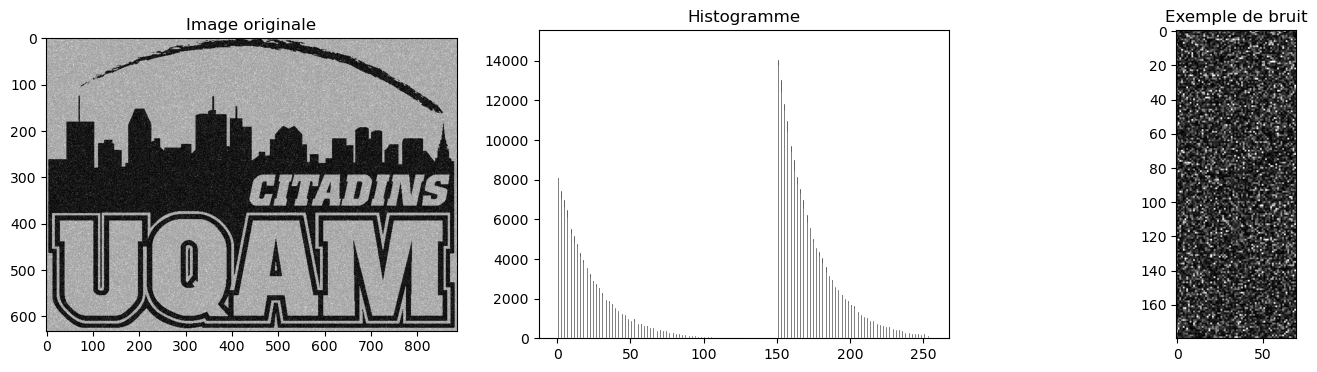

In [7]:
slice_bruit_blanche = im_ex1[0:180, 0: 70]
plt.figure(figsize=(18,4))
plt.subplot(131);plt.imshow(im_ex1, cmap='gray');plt.title('Image originale')
plt.subplot(132);plt.hist(im_ex1.ravel(), bins=256, range=(0, 255), fc='k', ec='w'); plt.title('Histogramme')
plt.subplot(133);plt.imshow(slice_bruit_blanche, cmap='gray');plt.title('Exemple de bruit')
plt.show()

### Étapes de la fonction
1. Extraire une sous-image (`slice_img`) à l'intérieur des coordonnées spécifiées.
2. Calculer la moyenne (µ) de la sous-image pour estimer la moyenne du bruit.
3. Calculer l'écart-type (σ) de la sous-image pour estimer la dispersion du bruit.
4. Calculer le paramètre `a` de la distribution exponentielle du bruit, défini comme \( a = 1 \ moyenne ).


### fonction stat
 
- Qui affiche les résultats : 
  - Moyenne (µ)
  - Écart-type (σ)
  - Paramètre `a`

In [10]:
def stat_bruit(img, x1, x2, y1, y2):
    """
    Cette fonction analyse une région spécifique d'une image pour estimer les paramètres
    statistiques nécessaires à l'étude du bruit exponentiel.

    Arguments :
    - img : ndarray
        L'image corrompue avec du bruit exponentiel.
    - x1, x2 : int
        Coordonnées des colonnes définissant la plage horizontale de la région à analyser.
    - y1, y2 : int
        Coordonnées des lignes définissant la plage verticale de la région à analyser.

    """
    # Extraction de la région d'intérêt dans l'image
    slice_img = img[y1:y2, x1:x2]

    # Calcul de la moyenne (µ) pour estimer l'espérance du bruit
    mean = np.mean(slice_img)

    # Calcul de l'écart-type (σ) pour évaluer la dispersion du bruit
    std_dev = np.std(slice_img)

    # Calcul du paramètre a de la distribution exponentielle (a = 1 / µ)
    a = 1 / mean

    # Affichage des résultats
    print(f"Mean (µ): {mean}")
    print(f"Standard Deviation (σ): {std_dev}")
    print(f"Parameter a: {a}")

### Utiliser cette fonction:
- fonction `stat_bruit` est utilisée pour l'image `tp3_ex1.tiff` corrompue avec du bruit exponentiel additif.
- Le paramètre `a` représente l'inverse de la moyenne du bruit. L'écart-type (σ) indique la variation du bruit autour de sa moyenne (µ).

In [12]:
stat_bruit(im_ex1, 0, 70, 0,180)

Mean (µ): 173.13857142857142
Standard Deviation (σ): 22.80709659518372
Parameter a: 0.005775720521135012


# Exercice 2 : Télescope spatial James-Webb

In [14]:
im_ex2 = imageio.imread('tp3_ex2.tiff')

### Definie une fonction avrage_dist:

- La fonction identifie les pixels correspondant à des régions d'intérêt (valeur 255).
- Pour chaque pixel blanc, calcule la distance euclidienne entre ce pixel et le centre de l'image.
- Retourne la moyenne de ces distances.


In [16]:
def avrage_dist(image: np.ndarray):
    """
    Calcule la distance moyenne entre les pixels blancs d'une image binaire
    et le centre de l'image.

    Parameters
    ----------
    image : np.ndarray
        Image binaire (niveaux de gris avec pixels valant soit 0, soit 255).

    Returns
    -------
    float
        Distance moyenne entre les pixels blancs et le centre de l'image.

    """
    n, m = image.shape  
    # Liste pour stocker les distances calculées
    res = []  
    for i in range(n):
        for j in range(m):
            # Identifier les pixels blancs
            if image[i, j] == 255:  
                # Calculer la distance euclidienne au centre
                d = math.sqrt((n / 2 - i) ** 2 + (m / 2 - j) ** 2)
                res.append(d)
    return np.mean(res) 


### Definie une fonction segmentation_img:
- Normalise l'image si elle n'est pas au format `uint8`.
- Binarise l'image pour isoler les zones d'intérêt.
- Applique un filtrage morphologique (ouverture) pour réduire le bruit.
- Détecte les contours à l'aide de l'algorithme de Canny.
- Utilise la transformée de Hough pour identifier des cercles dans l'image.
- Retourne une nouvelle image contenant uniquement les cercles détectés.


In [18]:
def segmentation_img(image: np.ndarray):
    """
    Segmente une image pour détecter les contours d'une étoile floue
    et identifie ses régions circulaires via la transformée de Hough.

    Parameters
    ----------
    image : np.ndarray
        Image (niveaux de gris ou autre) à analyser.

    Returns
    -------
    np.ndarray
        Image binaire avec les cercles détectés dessinés.

    """
    # Normalisation de l'image si ce n'est pas un format 8 bits
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # Binarisation avec un seuil adaptatif (OTSU)
    _, bin_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Réduction du bruit avec une ouverture morphologique
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    # Détection des contours avec Canny
    edges = canny(bin_img, sigma=3)

    # Détection des cercles via transformée de Hough
    hough_radii = np.arange(15, 30, 2)  # Rayon des cercles à chercher
    hough_res = hough_circle(edges, hough_radii)

    # Récupération des cercles les plus significatifs
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

    # Création d'une nouvelle image avec les cercles détectés
    circle_img = np.zeros_like(bin_img)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        circle_img[circy, circx] = 255

    return circle_img


### Usage segmentation_img:
- Employée pour détecter les contours flous d'une étoile.
- Permet de localiser l'étoile dans une image différenciée pour calculer les ajustements nécessaires.

In [20]:
# Algorithme de calibration à compléter
def calibration(telescope: tp3.JamesWebbSimulator, image: np.ndarray) -> tp3.JamesWebbSimulator:
    """ Calibration du télescope.
    Parameters
    ----------
    telescope: tp3.JamesWebbSimulator
        Télescope à calibrer
    image: np.ndarray
        Image à utiliser pour la calibration (étoile isolée HD84406)
    Returns
    -------
    telescope: tp3.JamesWebbSimulator
        Télescope calibré
    """
    ## Pour chaque miroir de votre télescope (`telescope.nb_mirrors`)
    for i in range(telescope.nb_mirrors):


        # TODO: Capture d'une image `im1` de l'étoile `HD84406`
        im1 = telescope.simulate(image)

        # TODO: Déplacer le miroir d'une distance de -100 pixels.
        telescope.move_mirror_by(i, -100)
        # TODO: Capture d'une image `im2` de l'étoile `HD84406`
        im2 = telescope.simulate(image)
        # TODO: Comparaison différentielle des images `im_d = im1 - im2` pour déterminer quelle étoile est associée à ce miroir
        im_d = im1 - im2
        # TODO: Segmentation de `im_d` et calcul de la position moyenne de l'étoile pour ce miroir._____-------------
        seg_bin = segmentation_img(im_d)
        bias = avrage_dist(seg_bin)
        # TODO: Calcul de la correction à appliquer à ce miroir pour le placer au centre du champ de vue.
        telescope.set_mirror_correction(i, bias)

        pass

    # TODO: Appliquer la correction pour chaque miroir

    return telescope

### Exemple de calibration 

In [22]:
telescope = tp3.JamesWebbSimulator('<forv26018703 >')

In [23]:
img_simulated = telescope.simulate(im_ex2)

In [24]:
telescope_res= calibration(telescope, im_ex2)
img_calib = telescope_res.simulate(im_ex2)

### Affichage

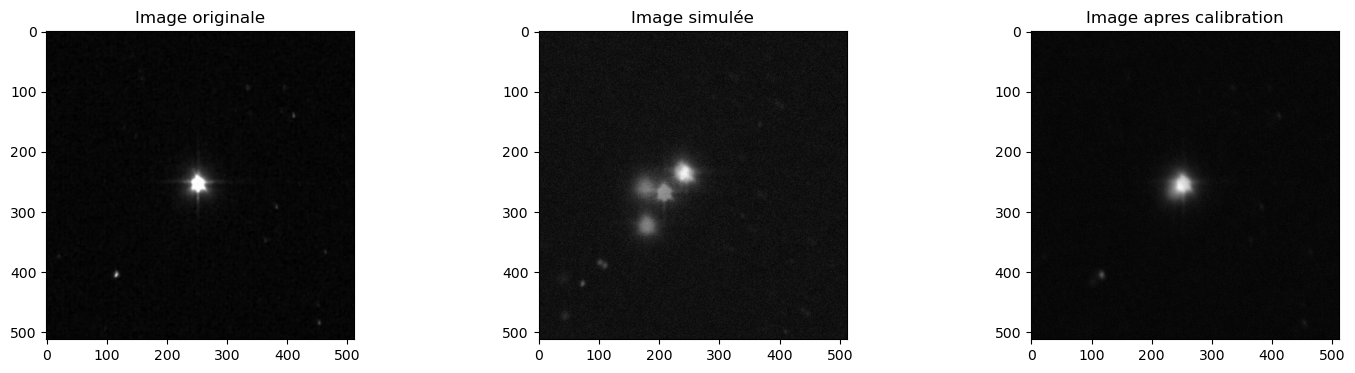

In [26]:
plt.figure(figsize=(18,4))
plt.subplot(131);plt.imshow(im_ex2, cmap='gray');plt.title('Image originale')
plt.subplot(132);plt.imshow(img_simulated, cmap='gray'); plt.title('Image simulée')
plt.subplot(133);plt.imshow(img_calib, cmap='gray');plt.title('Image apres calibration')
plt.show()